In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io
import skimage
from skimage.measure import find_contours

def getSmallestNeighborIndex(img, row, col):
    min_row_id = -1
    min_col_id = -1
    min_val = np.inf
    h, w = img.shape
    for row_id in range(row - 1, row + 2):
        if row_id < 0 or row_id >= h:
            continue
        for col_id in range(col - 1, col + 2):
            if col_id < 0 or col_id >= w:
                continue
            if row_id == row and col_id == col:
                continue
            if img[row_id, col_id] < min_val:
                min_row_id = row_id
                min_col_id = col_id
                min_val = img[row_id, col_id]
    return min_row_id, min_col_id


def getRegionalMinima(img):
    regional_minima = np.zeros(img.shape, dtype=np.int32)
    h, w = img.shape
    #Your code here
    # Compute the local minima in the given image
    # Compare each pixel to its 8-connected neighbours
    # Mark it as a local minimum if its value is smaller than all 8-connected neighbours
    # The output of this function is a 32-bit integral image that contains non-zero labels for all local minima pixels and zero everywhere else

    # Initial first
    number = 1
    for x in range(0, h):
      for y in range(0, w):
        # Find smallest value in 8-connected neighbours
        smallest_neighbor = getSmallestNeighborIndex(img, x, y)
        # If current value is smaller than or equal to the smallest_neighbor, label it non-zero
        if img[x, y] <= img[smallest_neighbor[0], smallest_neighbor[1]]:
          regional_minima[x, y] = number
          # Plus 1 and go to find next
          number = number + 1
    # return the regional_minima matrix
    return regional_minima


def iterativeMinFollowing(img, markers):
    markers_copy = np.copy(markers)
    h, w = img.shape
    while True:
        #Your code here
        # This function uses the minimum algorithm 
        # to label the unlabeled pixels in the marker image generated by getRegionalMinima(img)
        # Set n_unmarked_pix = 0
        n_unmarked_pix = 0
        for x in range(0, h):
          for y in range(0, w):

            # 1. If p has a zero value, change it
            p = markers_copy[x, y]
            if p == 0:
              # 2. Find the pixel with the smallest intensity value in the 8 connected neighbourhood of p
              smallest_neighbor = getSmallestNeighborIndex(img, x, y)

              # 3. If the smallest neighbour's label is non-zero, mark p with its label
              # Otherwise, leave it unchanged
              smallest_neighbour_label = markers_copy[smallest_neighbor[0], smallest_neighbor[1]]
              if smallest_neighbour_label != 0:
                markers_copy[x, y] = smallest_neighbour_label 
              else:
                n_unmarked_pix = n_unmarked_pix + 1

        # Print the count of unlabeled pixels number after a pass is over
        print('n_unmarked_pix: ', n_unmarked_pix)

        # If the count is zero after a pass, the entire image has been labeled and done
        if n_unmarked_pix == 0:
          return markers_copy

test_image = np.loadtxt('/content/A4_test_image.txt')
markers = getRegionalMinima(test_image)
print(markers)
labels = iterativeMinFollowing(test_image, markers)
print(labels)
  

[[0 0 0 1 0]
 [0 2 0 0 0]
 [0 0 0 0 0]
 [3 0 4 0 0]
 [0 0 0 0 0]
 [0 0 0 0 5]]
n_unmarked_pix:  0
[[2 2 1 1 1]
 [2 2 1 1 1]
 [3 4 4 4 1]
 [3 4 4 4 1]
 [3 4 4 4 4]
 [4 4 4 4 5]]


n_unmarked_pix:  1186
n_unmarked_pix:  491
n_unmarked_pix:  182
n_unmarked_pix:  59
n_unmarked_pix:  18
n_unmarked_pix:  4
n_unmarked_pix:  0


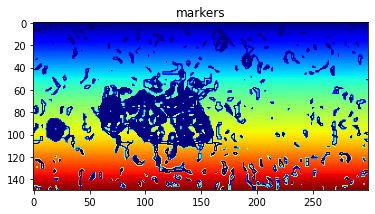

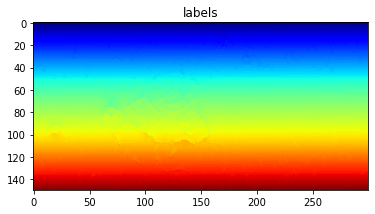

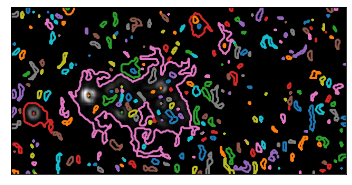

In [5]:
def imreconstruct(marker, mask):
    curr_marker = (np.copy(marker)).astype(mask.dtype)
    kernel = np.ones([3, 3])
    while True:
        next_marker = cv2.dilate(curr_marker, kernel, iterations=1)
        intersection = next_marker > mask
        next_marker[intersection] = mask[intersection]
        #perform morphological reconstruction of the image marker under the image mask, and returns the reconstruction in imresonctruct
        if np.array_equal(next_marker,curr_marker):
          return curr_marker
        curr_marker = next_marker.copy()

    return curr_marker


def imimposemin(marker, mask):
    # adapted from its namesake in MATLAB
    fm = np.copy(mask)
    fm[marker] = -np.inf
    fm[np.invert(marker)] = np.inf
    if mask.dtype == np.float32 or mask.dtype == np.float64:
        range = float(np.max(mask) - np.min(mask))
        if range == 0:
            h = 0.1
        else:
            h = range * 0.001
    else:
        # Add 1 to integer images.
        h = 1
    fp1 = mask + h
    g = np.minimum(fp1, fm)#If marker:-inf. Else:(||grad||+h)
    return np.invert(imreconstruct(
        np.invert(fm.astype(np.uint8)), np.invert(g.astype(np.uint8))
    ).astype(np.uint8))

sigma = 2.5
img_name = '/content/img_A4_P1.bmp'
img_rgb = io.imread(img_name).astype(np.float32)
img_gs = skimage.color.rgb2gray(img_rgb)

img_blurred = cv2.GaussianBlur(img_gs, (int(2 * round(3 * sigma) + 1), int(2 * round(3 * sigma) + 1)), sigma
                     )#borderType=cv2.BORDER_REPLICATE

[img_grad_y, img_grad_x] = np.gradient(img_blurred)
img_grad = np.square(img_grad_x) + np.square(img_grad_y)

# refined blob locations generated generated in part 3 of lab 6
blob_markers = np.loadtxt('/content/A4_blob_markers.txt', dtype=np.bool, delimiter='\t')

img_grad_min_imposed = imimposemin(blob_markers, img_grad)

markers = getRegionalMinima(img_grad_min_imposed)
plt.figure(0)
plt.imshow(markers,cmap='jet')
plt.title('markers')

labels = iterativeMinFollowing(img_grad_min_imposed, np.copy(markers))
plt.figure(1)
plt.imshow(labels,cmap='jet')
plt.title('labels')

#contour of img_grad_min_imposed
contours = find_contours(img_grad_min_imposed,0.8)
contour_id = 0
pruned_contours = []
n_pruned_contours = 0

fig,ax=plt.subplots()
ax.imshow(img_grad_min_imposed, interpolation='nearest', cmap=plt.cm.gray)#
for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)



ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

